# Preliminary Predictions

In this dataset we will import a subset of the data and make some preliminary predictions, using some pre-trained models in order to understand which models and tecnicques are more suitable for this dataset.

In [1]:
# Define the path to the dataset directory
DATASET_PATH = '../.data/'
IMAGE_SIZE = 160
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
IMAGES_PER_CLASS = 10

## Dataset import

In [2]:
import tensorflow as tf

train_dataset = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=VALIDATION_SPLIT,
  subset="training",
  seed=123,
  image_size=IMAGE_SHAPE,
  batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [3]:
class_names = train_dataset.class_names
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


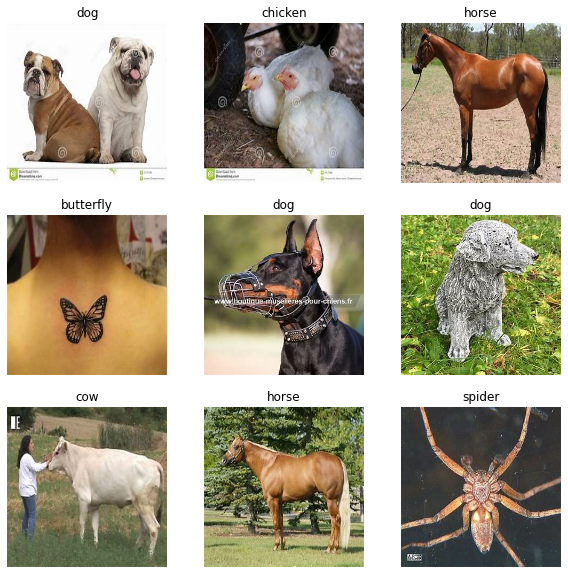

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Since we don't have a test set, we are gonna extract it from the validation set, using a fifth of the data.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 132
Number of test batches: 32


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

To improve the performance of the model, we will use data augmentation. This will help the model generalize better and reduce overfitting.

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

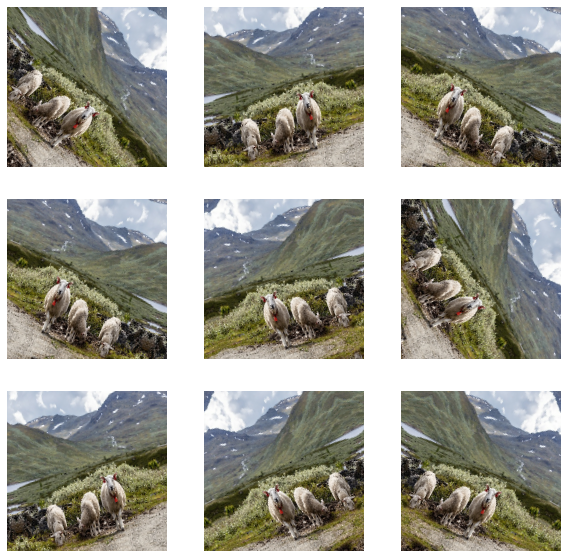

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model Preparation

The data will be preprocessed using the `MobileNet_v2` for feature extraction.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

We aree also gonna rescale the data to the range [-1, 1].

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Our base model will be the `MobileNet_v2`.

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMAGE_SHAPE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


The model will be trained for 5 epochs with the `base_model` frozen. Then for 5 epochs with the `base_model` unfrozen.

In [14]:
base_model.trainable = False

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

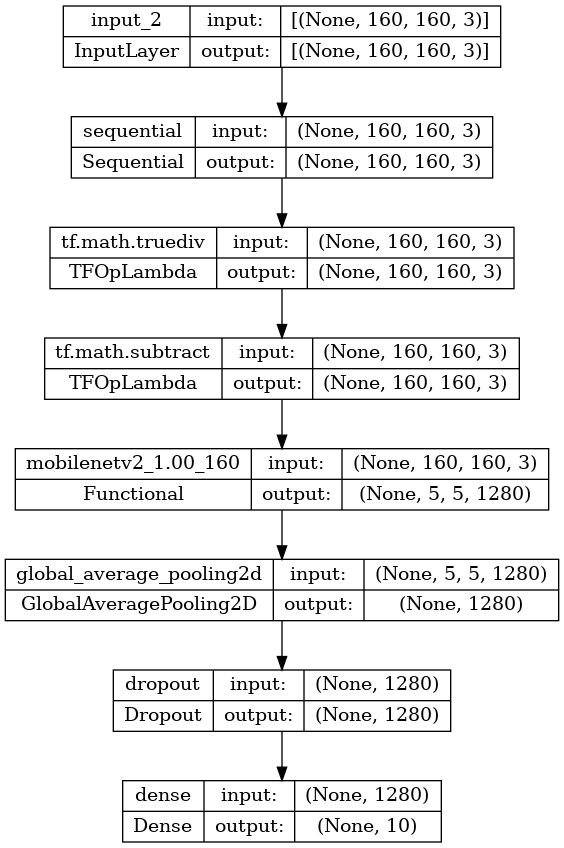

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [21]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)

132/132 [==============================] - 25s 182ms/step - loss: 2.8531 - accuracy: 0.0482


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.85
initial accuracy: 0.05


In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
655/655 [==============================] - 154s 231ms/step - loss: 1.3207 - accuracy: 0.5778 - val_loss: 0.5217 - val_accuracy: 0.8777
Epoch 2/5
655/655 [==============================] - 152s 232ms/step - loss: 0.6008 - accuracy: 0.8169 - val_loss: 0.3306 - val_accuracy: 0.9143
Epoch 3/5
655/655 [==============================] - 147s 224ms/step - loss: 0.4828 - accuracy: 0.8506 - val_loss: 0.2657 - val_accuracy: 0.9288
Epoch 4/5
655/655 [==============================] - 150s 229ms/step - loss: 0.4239 - accuracy: 0.8626 - val_loss: 0.2352 - val_accuracy: 0.9345
Epoch 5/5
655/655 [==============================] - 150s 229ms/step - loss: 0.3944 - accuracy: 0.8740 - val_loss: 0.2157 - val_accuracy: 0.9368


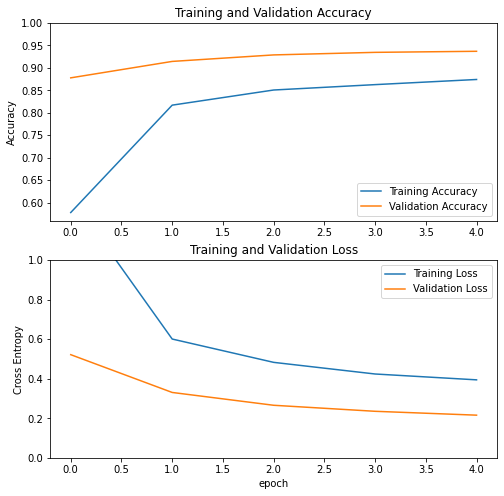

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [30]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 6/10


655/655 [==============================] - 218s 324ms/step - loss: 0.3974 - accuracy: 0.8718 - val_loss: 0.1912 - val_accuracy: 0.9409
Epoch 7/10
655/655 [==============================] - 208s 317ms/step - loss: 0.2753 - accuracy: 0.9128 - val_loss: 0.2052 - val_accuracy: 0.9323
Epoch 8/10
655/655 [==============================] - 192s 294ms/step - loss: 0.2410 - accuracy: 0.9220 - val_loss: 0.1589 - val_accuracy: 0.9525
Epoch 9/10
655/655 [==============================] - 191s 292ms/step - loss: 0.2039 - accuracy: 0.9329 - val_loss: 0.1814 - val_accuracy: 0.9482
Epoch 10/10
655/655 [==============================] - 192s 293ms/step - loss: 0.1921 - accuracy: 0.9362 - val_loss: 0.1765 - val_accuracy: 0.9461


In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

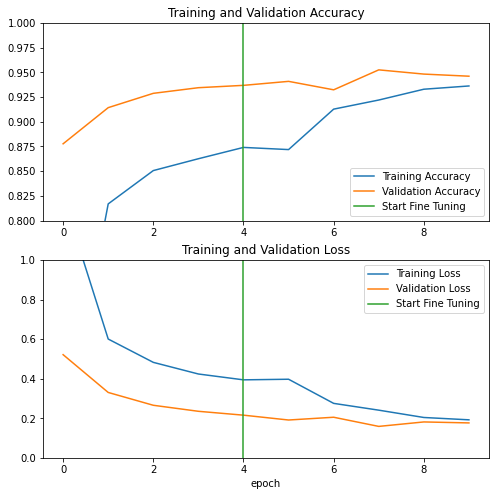

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

As expected, after the fine tuning phase, the model performs better.

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

32/32 [==============================] - 5s 168ms/step - loss: 0.1657 - accuracy: 0.9541
Test accuracy : 0.9541015625


The overall accuracy is pretty satisfying, considering that it was only trained for 10 epochs. It may be possible to improve the performance by training the model for more epochs.